The first few cells perform RF with the simple train-test split, then we turn into using the cross-validation approach. 
Final corrected code starts from the cell starting with (CODE STARTS FROM HERE)

Fitting 3 folds for each of 1 candidates, totalling 3 fits

✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 400}

Classification Report:
              precision    recall  f1-score   support

         AFM       0.56      0.20      0.29       692
          FM       0.79      0.92      0.85      8005
         FiM       0.68      0.27      0.39      1082
          NM       0.96      0.94      0.95     12538

    accuracy                           0.88     22317
   macro avg       0.75      0.58      0.62     22317
weighted avg       0.87      0.88      0.87     22317



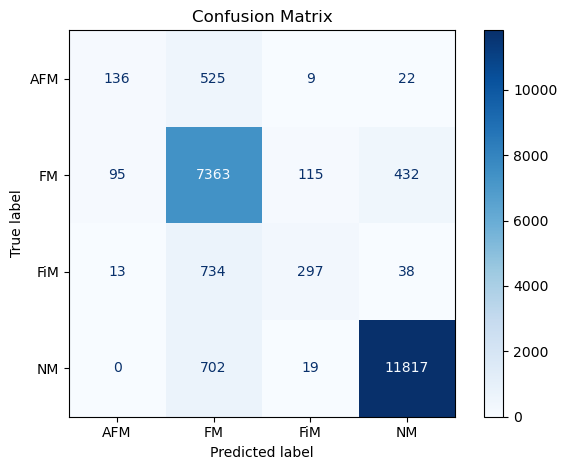

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

df = pd.read_csv("All Data Imported.csv")

def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]

df["elements"] = df["elements"].apply(parse_elements)

def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"

df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

numerical_features = ["cbm", "vbm","energy_above_hull", "band_gap", "density_atomic", "numberofelements","volume","nsites","density","efermi","formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

#  One-hot encode elements 
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# One-hot encode crystal system 
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

#  Combine all features
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# Encode target 
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

#  Stratified Train/Test Split 
if df.shape[0] > 0 and len(np.unique(y)) > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    # GridSearchCV to find best Random Forest parameters 
    param_grid = {
        'n_estimators': [400],
        'max_depth': [50],
        'class_weight': ['balanced'],       
        'min_samples_split': [5],
    }

    grid_search = GridSearchCV(
        RandomForestClassifier(random_state=42),
        param_grid,
        scoring='f1_macro',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_

    print(f"\n Best Parameters: {grid_search.best_params_}\n")

    # === 11. Predict and Report ===
    y_pred = best_clf.predict(X_test)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # === 12. Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("❗ Not enough data or diversity in target classes to perform training.")



🔍 Top 20 Most Important Features:
                      Feature  Importance
3                    band_gap    0.117512
4              density_atomic    0.073659
10  formation_energy_per_atom    0.071595
2           energy_above_hull    0.070595
0                         cbm    0.065645
6                      volume    0.058111
8                     density    0.055683
1                         vbm    0.055057
9                      efermi    0.049743
7                      nsites    0.049005
53                         Mn    0.024071
35                         Fe    0.023678
5            numberofelements    0.019785
62                          O    0.019260
50                         Li    0.017016
27                         Co    0.015240
28                         Cr    0.013268
93                          V    0.010535
60                         Ni    0.010123
37                         Gd    0.007949


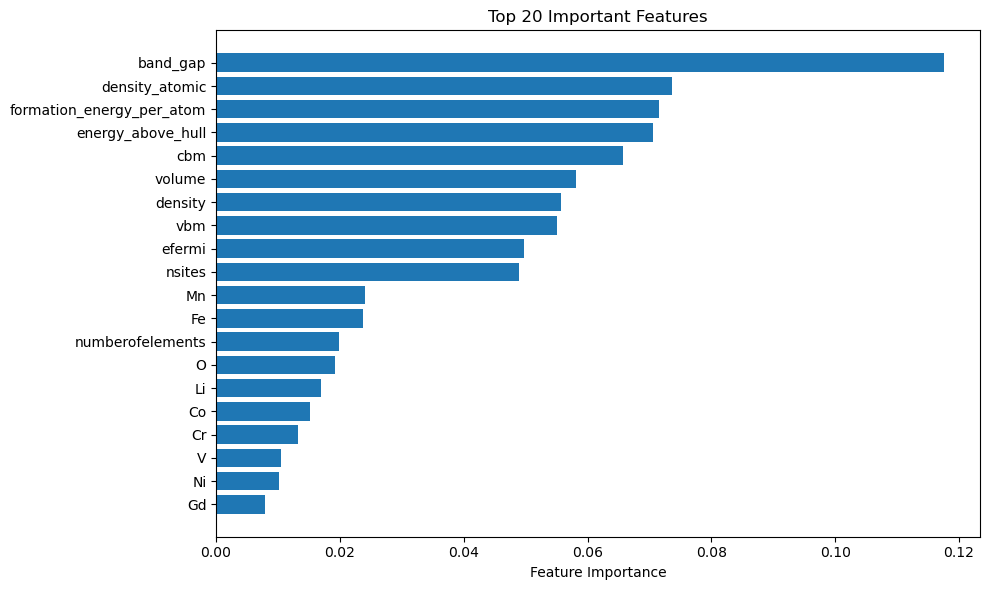

In [5]:
#Feature Importance

# === 13. Feature Importance Plot ===
importances = best_clf.feature_importances_
feature_names = X.columns

# Create a DataFrame for sorting
feat_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display top 20
top_n = 20
print("\n🔍 Top {} Most Important Features:".format(top_n))
print(feat_importances.head(top_n))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_importances['Feature'].head(top_n)[::-1], 
         feat_importances['Importance'].head(top_n)[::-1])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Important Features")
plt.tight_layout()
plt.show()



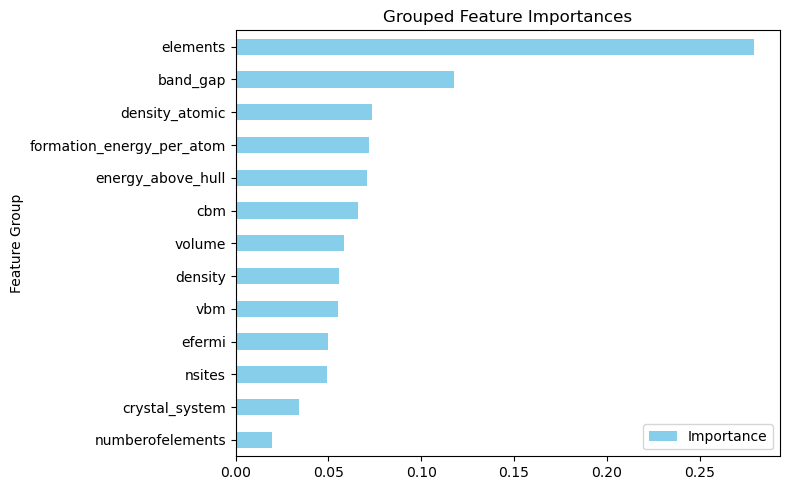

In [6]:
# Grouped feature importance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Feature importances from the best model (after GridSearch)
importances = best_clf.feature_importances_
feature_names = X.columns

#"cbm", "vbm","energy_above_hull", "band_gap", "density_atomic", "numberofelements","volume","nsites","density","efermi","formation_energy_per_atom"

# Grouping
grouped_importance = {
    'cbm':0,
    'vbm': 0,
    'energy_above_hull': 0,
    'formation_energy_per_atom': 0,
    'band_gap': 0,
    'density_atomic': 0,
    'volume': 0,
    'efermi': 0,
    'density': 0,
    'nsites': 0,
    'numberofelements': 0,
    'elements': 0,
    'crystal_system': 0
}

for name, imp in zip(feature_names, importances):
    if name in grouped_importance:
        grouped_importance[name] += imp
    elif name in mlb.classes_:  # element one-hot
        grouped_importance["elements"] += imp
    elif name.startswith("crysys_"):
        grouped_importance["crystal_system"] += imp

# Plot
group_df = pd.DataFrame(list(grouped_importance.items()), columns=["Feature Group", "Importance"])
group_df.sort_values("Importance", ascending=True).plot.barh(x="Feature Group", y="Importance", figsize=(8,5), color="skyblue")
plt.title("Grouped Feature Importances")
plt.tight_layout()
plt.show()


Fitting 4 folds for each of 72 candidates, totalling 288 fits


/home/ahmedfahmy177/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 8, 'n_estimators': 400}

Cross-validation F1 scores: [0.6213559  0.63541701 0.63546684 0.63226946]
Mean CV score: 0.6311

📊 Validation Classification Report:
              precision    recall  f1-score   support

         AFM       0.52      0.31      0.38       554
          FM       0.79      0.90      0.84      6404
         FiM       0.62      0.32      0.42       865
          NM       0.96      0.94      0.95     10031

    accuracy                           0.88     17854
   macro avg       0.72      0.62      0.65     17854
weighted avg       0.87      0.88      0.87     17854



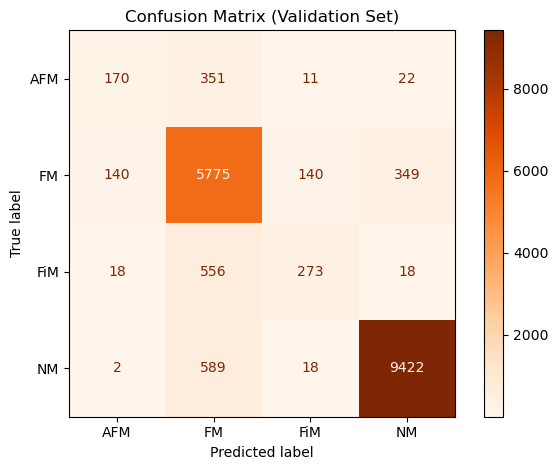


🧪 Test Classification Report:
              precision    recall  f1-score   support

         AFM       0.45      0.25      0.32       554
          FM       0.79      0.90      0.84      6405
         FiM       0.62      0.34      0.44       865
          NM       0.96      0.93      0.95     10030

    accuracy                           0.87     17854
   macro avg       0.70      0.61      0.64     17854
weighted avg       0.87      0.87      0.86     17854



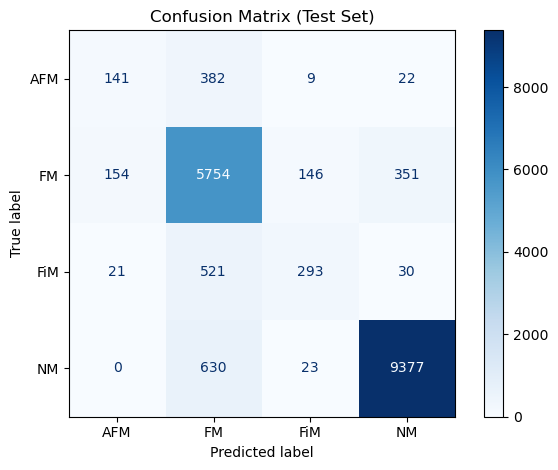

In [1]:
# Corrected RF with 4-fold CV

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === 1. Load CSV ===
df = pd.read_csv("All Data Imported.csv")

# === 2. Parse elements column: ['Element Fe', 'Element O'] → ['Fe', 'O'] ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]

df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system from symmetry column ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"

df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing essential features ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# === 6. One-hot encode crystal system ===
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine all features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 9. Split: 80% (train+val) and 20% (test) ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# === 10. Split 80% into 60% (train) and 20% (val) ===
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 11. Setup CV and Grid Search ===
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [100, 250, 400],
    'max_depth': [30, 40, 50, 60],
    'min_samples_split': [3,5,8],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='f1_macro',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

# === 12. Fit on training set ===
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

# === 13. Cross-validation scores on training set ===
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

# === 14. Evaluate on validation set ===
print("\n📊 Validation Classification Report:")
y_pred_val = best_clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=le.classes_)
disp_val.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

# === 15. Final evaluation on test set ===
print("\n🧪 Test Classification Report:")
y_pred_test = best_clf.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=le.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


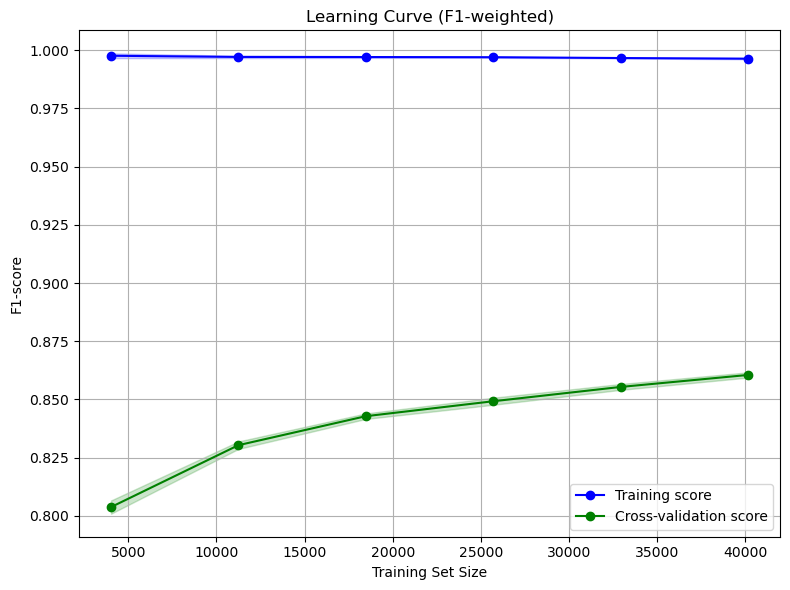

In [11]:
# Learning Curve Plot (Checking for overfitting)

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# You already have this model
model = best_clf  # from GridSearchCV

train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train,
    train_sizes=np.linspace(0.1, 1.0, 6),  # from 10% to 100% of training data
    cv=4,
    scoring='f1_weighted',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Compute means and standard deviations
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

train_std = np.std(train_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training score")
plt.plot(train_sizes, val_mean, 'o-', color="green", label="Cross-validation score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="green")
plt.title("Learning Curve (F1-weighted)")
plt.xlabel("Training Set Size")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


Class distribution before SMOTE: Counter({3: 30089, 1: 19212, 2: 2596, 0: 1662})
Class distribution after SMOTE: Counter({1: 30089, 3: 30089, 2: 30089, 0: 30089})
Fitting 4 folds for each of 2 candidates, totalling 8 fits

✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': 50, 'min_samples_split': 5, 'n_estimators': 250}

Cross-validation F1 scores: [0.89881337 0.89769852 0.9008892  0.90244894]
Mean CV score: 0.9000

📊 Validation Classification Report:
              precision    recall  f1-score   support

         AFM       0.48      0.35      0.40       554
          FM       0.79      0.87      0.83      6404
         FiM       0.48      0.35      0.41       865
          NM       0.95      0.93      0.94     10031

    accuracy                           0.86     17854
   macro avg       0.68      0.62      0.65     17854
weighted avg       0.86      0.86      0.86     17854



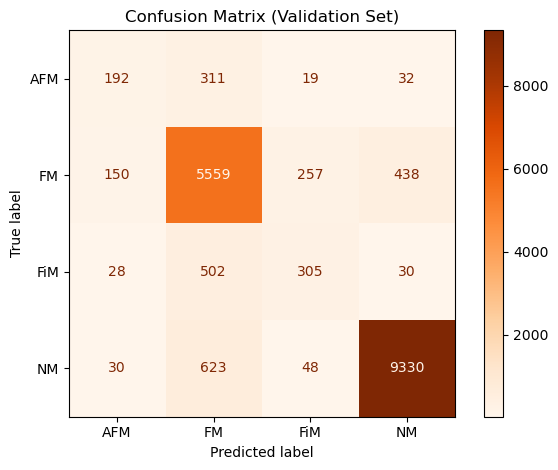


🧪 Test Classification Report:
              precision    recall  f1-score   support

         AFM       0.46      0.32      0.38       554
          FM       0.79      0.87      0.83      6405
         FiM       0.50      0.38      0.43       865
          NM       0.95      0.93      0.94     10030

    accuracy                           0.86     17854
   macro avg       0.68      0.62      0.64     17854
weighted avg       0.86      0.86      0.86     17854



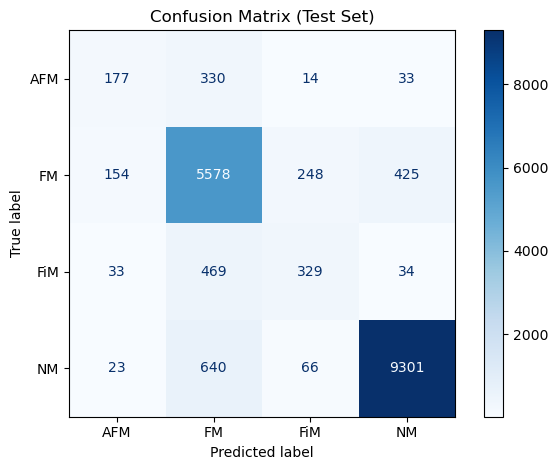

In [ ]:
# === Corrected RF with 4-fold CV + SMOTE ===

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

# === 1. Load CSV ===
df = pd.read_csv("All Data Imported.csv")

# === 2. Parse elements column ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]

df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"

df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing essential features ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# === 6. One-hot encode crystal system ===
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine all features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 9. Split: 80% train+val, 20% test ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# === 10. Split 80% into 60% train, 20% val ===
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 11. Apply SMOTE to training set ===
print("Class distribution before SMOTE:", Counter(y_train))
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_train_resampled))

# === 12. Setup CV and GridSearch ===
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [100, 250, 400],
    'max_depth': [30, 40, 50, 60],
    'min_samples_split': [3,5,8],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='f1_macro',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

# === 13. Train on SMOTE-resampled training set ===
grid_search.fit(X_train_resampled, y_train_resampled)
best_clf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

# === 14. Cross-validation on resampled training set ===
cv_scores = cross_val_score(best_clf, X_train_resampled, y_train_resampled, cv=skf, scoring='f1_macro', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

# === 15. Evaluate on validation set ===
print("\n📊 Validation Classification Report:")
y_pred_val = best_clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=le.classes_)
disp_val.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

# === 16. Final evaluation on test set ===
print("\n🧪 Test Classification Report:")
y_pred_test = best_clf.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=le.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


Fitting 4 folds for each of 1 candidates, totalling 4 fits

✅ Best Parameters: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_split': 8, 'n_estimators': 400}

Cross-validation F1 scores: [0.6213559  0.63541701 0.63546684 0.63226946]
Mean CV score: 0.6311

📊 Validation Classification Report:
              precision    recall  f1-score   support

         AFM       0.52      0.31      0.38       554
          FM       0.79      0.90      0.84      6404
         FiM       0.62      0.32      0.42       865
          NM       0.96      0.94      0.95     10031

    accuracy                           0.88     17854
   macro avg       0.72      0.62      0.65     17854
weighted avg       0.87      0.88      0.87     17854



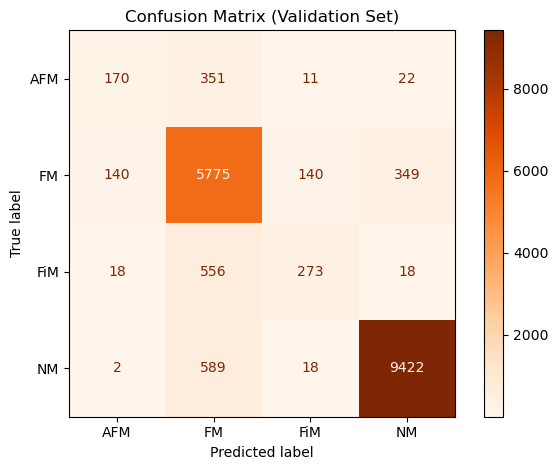

In [ ]:
# Redoing the above RF with 4-fold CV with best parameters found (CODE STARTS FROM HERE)

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# === 1. Load CSV ===
df = pd.read_csv("All Data Imported.csv")

# === 2. Parse elements column: ['Element Fe', 'Element O'] → ['Fe', 'O'] ===
def parse_elements(val):
    if pd.isna(val):
        return []
    return [e.strip().split()[-1] for e in str(val).strip("[]").split(",")]

df["elements"] = df["elements"].apply(parse_elements)

# === 3. Extract crystal system from symmetry column ===
def extract_crystal_system(symmetry_str):
    if pd.isna(symmetry_str):
        return "Unknown"
    match = re.search(r"crystal_system=<CrystalSystem\.\w+: '(\w+)'", str(symmetry_str))
    return match.group(1) if match else "Unknown"

df["crystal_system"] = df["symmetry"].apply(extract_crystal_system)

# === 4. Drop rows with missing essential features ===
numerical_features = ["cbm", "vbm", "energy_above_hull", "band_gap", "density_atomic",
                      "numberofelements", "volume", "nsites", "density", "efermi", "formation_energy_per_atom"]
df = df.dropna(subset=numerical_features + ["ordering"])

# === 5. One-hot encode elements ===
mlb = MultiLabelBinarizer()
element_df = pd.DataFrame(mlb.fit_transform(df["elements"]), columns=mlb.classes_)

# === 6. One-hot encode crystal system ===
crystal_df = pd.get_dummies(df["crystal_system"], prefix="crysys")

# === 7. Combine all features ===
X = pd.concat([
    df[numerical_features].reset_index(drop=True),
    element_df.reset_index(drop=True),
    crystal_df.reset_index(drop=True)
], axis=1)

# === 8. Encode target ===
le = LabelEncoder()
y = le.fit_transform(df["ordering"])

# === 9. Split: 80% (train+val) and 20% (test) ===
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# === 10. Split 80% into 60% (train) and 20% (val) ===
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# === 11. Setup CV and Grid Search ===
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

param_grid = {
    'n_estimators': [400],
    'max_depth': [30],
    'min_samples_split': [8],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='f1_macro',
    cv=skf,
    n_jobs=-1,
    verbose=1
)

# === 12. Fit on training set ===
grid_search.fit(X_train, y_train)
best_clf = grid_search.best_estimator_
print(f"\n✅ Best Parameters: {grid_search.best_params_}\n")

# === 13. Cross-validation scores on training set ===
cv_scores = cross_val_score(best_clf, X_train, y_train, cv=skf, scoring='f1_macro', n_jobs=-1)
print(f"Cross-validation F1 scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f}")

# === 14. Evaluate on validation set ===
print("\n📊 Validation Classification Report:")
y_pred_val = best_clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=le.classes_))

cm_val = confusion_matrix(y_val, y_pred_val)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=le.classes_)
disp_val.plot(cmap="Oranges", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()



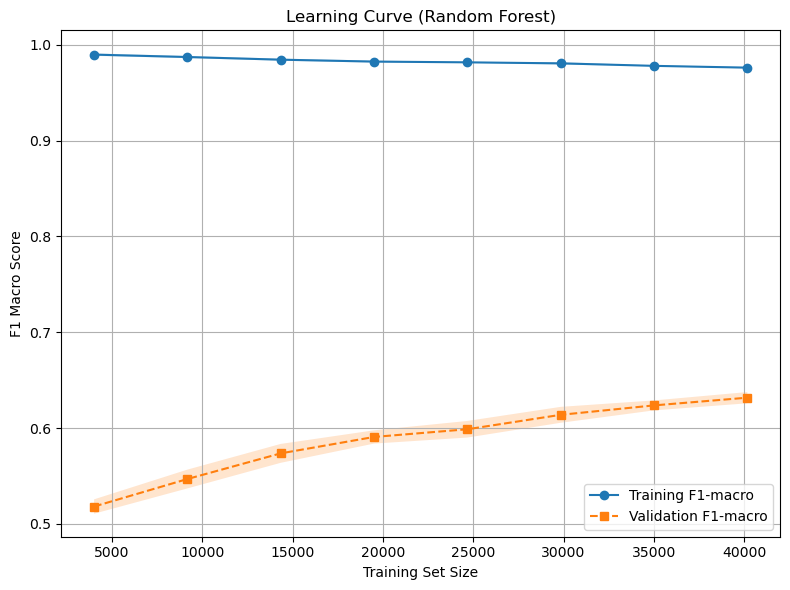

In [2]:
from sklearn.model_selection import learning_curve

# === Learning curve ===
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_clf,
    X=X_train,
    y=y_train,
    cv=skf,
    scoring='f1_macro',
    train_sizes=np.linspace(0.1, 1.0, 8),
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# === Mean & std ===
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# === Plot ===
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Training F1-macro")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, 's--', label="Validation F1-macro")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("Learning Curve (Random Forest)")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Macro Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


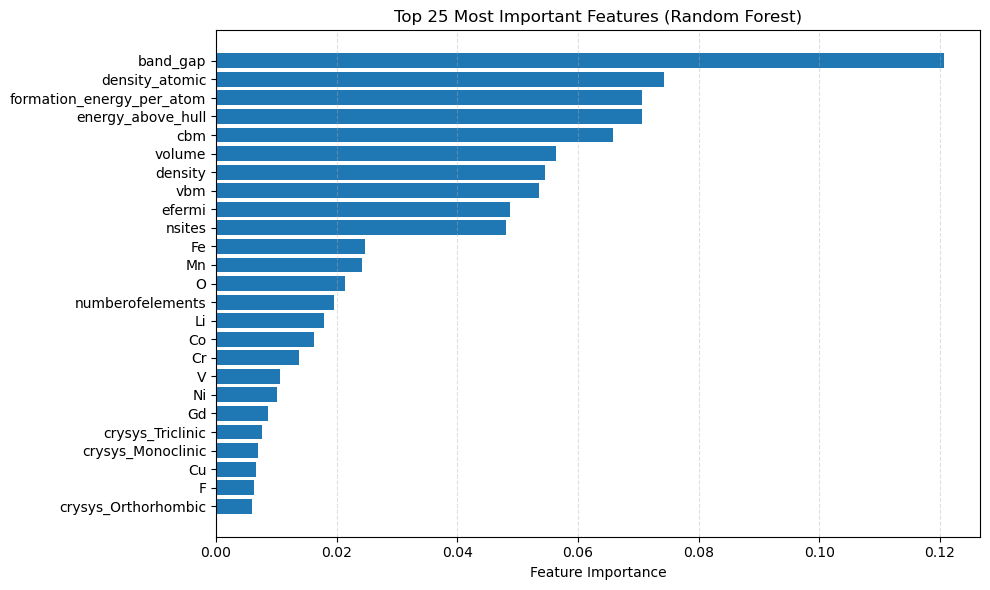

In [3]:
# === Extract individual feature importances ===
importances = best_clf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# === Sort by importance ===
top_n = 25  # adjust as needed
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=False).head(top_n)

# === Plot top N features ===
plt.figure(figsize=(10, 6))
plt.barh(importance_df_sorted["Feature"][::-1], importance_df_sorted["Importance"][::-1])
plt.xlabel("Feature Importance")
plt.title(f"Top {top_n} Most Important Features (Random Forest)")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.show()


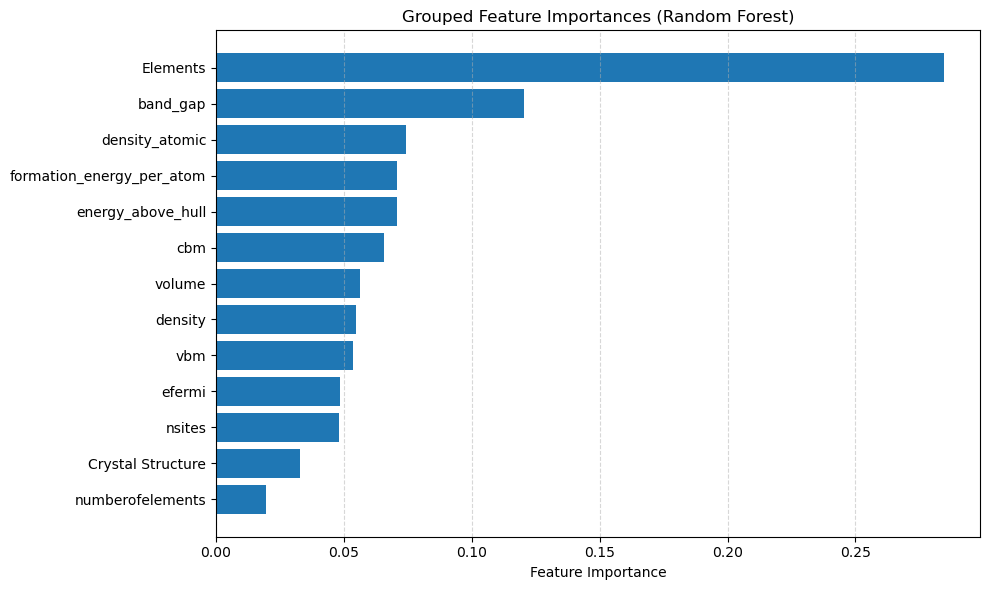

In [4]:
# === Feature groups reconstruction ===
num_features = df[numerical_features].columns.tolist()
element_features = element_df.columns.tolist()
crysys_features = crystal_df.columns.tolist()

# === Extract importances and assign groups ===
importances = best_clf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

def categorize_feature(name):
    if name in num_features:
        return name  # keep as-is
    elif name in element_features:
        return "Elements"
    elif name in crysys_features:
        return "Crystal Structure"
    else:
        return "Other"

importance_df["Category"] = importance_df["Feature"].apply(categorize_feature)

# === Group: sum Elements and Crystal Structure, keep numerical ===
grouped_df = importance_df.groupby("Category")["Importance"].sum().reset_index()
grouped_df = grouped_df.sort_values(by="Importance", ascending=False)

# === Plot ===
plt.figure(figsize=(10, 6))
plt.barh(grouped_df["Category"][::-1], grouped_df["Importance"][::-1])
plt.xlabel("Feature Importance")
plt.title("Grouped Feature Importances (Random Forest)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
